In [1]:
import sys; sys.path.append("../")

In [2]:
from dataset_wrappper import NewsData
from utils_train import transfer_batch_to_device
import os
from run_validation import load_model_for_eval
from pathlib import Path
import matplotlib.pyplot as plt
from transformers import RobertaTokenizerFast
import torch
import torch.nn.functional as F
from utils_evaluation import tokenizer_batch_decode
import numpy as np
import pickle
import tqdm

plt.style.reload_library()
plt.style.use('thesis_style')

%matplotlib inline

In [3]:
BATCH_SIZE = 64
DEVICE = "cuda:0"
CHECKPOINT_TYPE = "best" # else "best"
RESULT_DIR = Path("result-files")

In [4]:
cmap = pickle.load( open( RESULT_DIR / "thesis-cmap.pkl", "rb" ) )

In [5]:
data = NewsData(batch_size=BATCH_SIZE, tokenizer_name="roberta", dataset_name="ptb_text_only", max_seq_len=64)
validation_loader = data.val_dataloader(batch_size=BATCH_SIZE)
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

print(f"{len(validation_loader)} batches with batch size {BATCH_SIZE}")

Is file!
train 42068
validation 3370
test 3761
53 batches with batch size 64


In [22]:
len(data.datasets["validation"])

3370

In [15]:
import math
import matplotlib

def orderOfMagnitude(number):
    return math.floor(math.log(number, 10))

class OOMFormatter(matplotlib.ticker.ScalarFormatter):
    def __init__(self, order=0, fformat="%1.1f", offset=True, mathText=True):
        self.oom = order
        self.fformat = fformat
        matplotlib.ticker.ScalarFormatter.__init__(self,useOffset=offset,useMathText=mathText)
    def _set_order_of_magnitude(self):
        self.orderOfMagnitude = self.oom
    def _set_format(self, vmin=None, vmax=None):
        self.format = self.fformat
        if self._useMathText:
             self.format = r'$\mathdefault{%s}$' % self.format

In [6]:
def get_clean_name(run_name):
    latent_size = run_name.split("-")[4][-2:]
    if "autoencoder" in run_name:
        FB = "autoencoder"
    else:
        FB = run_name.split("-")[6]
        if len(FB) == 3:
            FB += "0"
        FB = "FB-" + FB
    clean_name = f"NZ-{latent_size} | {FB}"
    return clean_name

In [7]:
PTB_run_name_paths = {}
for r in os.listdir("../Runs"):
    if "PTB" in r:
        path = Path("../Runs") / r / f"checkpoint-{CHECKPOINT_TYPE}.pth"
        PTB_run_name_paths[r] = path

for r in PTB_run_name_paths.keys():
    print(get_clean_name(r))

NZ-32 | FB-0.50
NZ-32 | FB-1.00
NZ-32 | FB-1.50
NZ-64 | FB-1.00
NZ-32 | FB-0.00
NZ-32 | autoencoder
NZ-64 | FB-0.50
NZ-64 | FB-1.50
NZ-64 | FB-0.00
NZ-64 | autoencoder
NZ-32 | FB-0.75
NZ-32 | FB-0.25
NZ-64 | FB-0.75
NZ-64 | FB-0.25


# 1 Accuracy drop decoding samples from prior versus posterior

In [8]:
# AUTO_REGRESSIVE = False
# MODE = 'TF' if AUTO_REGRESSIVE is False else 'AR'

all_acc_drop_results = {}

for MODE, AUTO_REGRESSIVE in zip(["TF", "AR"], [False, True]):
    RESULT_FILE = RESULT_DIR / f"result_acc_drop_{MODE}.pickle"
    
    # If already ran, do not run again
    if os.path.exists(RESULT_FILE):
        print(f"Loading file {RESULT_FILE}, it existed.")
        results_acc_drop = pickle.load( open( RESULT_FILE, "rb" ) )
    else:
        results_acc_drop = {}
    
    for r, p in PTB_run_name_paths.items():
        print(r)
        
        if r in results_acc_drop:
            print("Did already do this. Skipping it.")
            continue

        accs_prior_samples = []
        accs_posterior_samples = []

        latent_size = int(r.split("-")[4][-2:])

        vae_model = load_model_for_eval(p, device_name="cuda:0", 
                                        latent_size=latent_size, 
                                        add_latent_via_memory=True,
                                        add_latent_via_embeddings=False, 
                                        do_tie_weights=True, 
                                        do_tie_embedding_spaces=True,
                                        add_decoder_output_embedding_bias=False)


        N = len(validation_loader)
        with torch.no_grad():
            for batch_i, batch in enumerate(validation_loader):
                print(f"{batch_i:3d}/{N}", end="\r")
                batch = transfer_batch_to_device(batch, DEVICE)
                for decode_sample_from_prior_mode in [False, True]:
                    vae_output = vae_model.forward(batch["input_ids"], 
                                                   1.0, 
                                                   batch["attention_mask"],
                                                   auto_regressive=AUTO_REGRESSIVE,
                                                    objective="beta-vae",
                                                    hinge_kl_loss_lambda=0.5,
                                                    return_latents=False,
                                                    return_log_q_z_x=False,
                                                    return_log_p_z=False,
                                                    return_mu_logvar=False,
                                                    return_exact_match=True,
                                                    return_cross_entropy=True,
                                                    return_embedding_distance=False,
                                                    reduce_seq_dim_embedding_loss="mean",
                                                    reduce_batch_dim_embedding_loss="mean",
                                                    return_predictions=True,
                                                    return_probabilities=False,
                                                    return_logits=False,
                                                    return_hidden_states=False,
                                                    return_last_hidden_state=False,
                                                    return_attention_to_latent=False,
                                                    return_attention_probs=False,
                                                    return_text_predictions=False,
                                                    tokenizer=None,
                                                    reduce_seq_dim_ce="none",
                                                    reduce_seq_dim_exact_match="none",
                                                    reduce_batch_dim_exact_match="none",
                                                    reduce_batch_dim_ce="none",
                                                    nucleus_sampling=False,
                                                    top_k=0,
                                                    top_p=0.9,
                                                    device_name="cuda:0",
                                                    decode_sample_from_prior=decode_sample_from_prior_mode)

                    labels = batch["input_ids"][:, 1:].contiguous()  # skip <s> token

                    # pad token is int 1
                    label_mask = (labels != 1).float()

                    masked_match = (vae_output["exact_match"] * label_mask)
                    masked_acc = (masked_match.sum(dim=-1) / label_mask.sum(dim=-1)).mean().item()

                    if decode_sample_from_prior_mode is True:
                        accs_prior_samples.append(masked_acc)
                    else:
                        accs_posterior_samples.append(masked_acc)

        results_acc_drop[r] ={
            "acc_prior": np.mean(accs_prior_samples),
            "acc_posterior": np.mean(accs_posterior_samples),
            "acc_drop": np.mean(accs_posterior_samples) - np.mean(accs_prior_samples)
        }

        # Dump results
        pickle.dump( results_acc_drop, open( RESULT_FILE, "wb" ) )
    
    all_acc_drop_results[MODE] = results_acc_drop
    break # <- skip AR for now

Loading file result-files/result_acc_drop_TF.pickle, it existed.
2021-02-03-PTB-latent32-FB-0.5-run-09:31:02
Did already do this. Skipping it.
2021-02-03-PTB-latent32-FB-1.0-run-11:43:17
Did already do this. Skipping it.
2021-02-03-PTB-latent32-FB-1.50-run-12:13:36
Did already do this. Skipping it.
2021-02-03-PTB-latent64-FB-1.0-run-13:06:00
Did already do this. Skipping it.
2021-02-03-PTB-latent32-FB-0.00-run-14:32:09
Did already do this. Skipping it.
2021-02-03-PTB-latent32-autoencoder-run-17:30:41
Did already do this. Skipping it.
2021-02-03-PTB-latent64-FB-0.50-run-12:29:58
Did already do this. Skipping it.
2021-02-03-PTB-latent64-FB-1.50-run-13:22:14
Did already do this. Skipping it.
2021-02-03-PTB-latent64-FB-0.00-run-17:14:10
Did already do this. Skipping it.
2021-02-03-PTB-latent64-autoencoder-run-18:25:57
Did already do this. Skipping it.
2021-02-02-PTB-latent32-FB-0.75-run-12:44:32
Did already do this. Skipping it.
2021-02-02-PTB-latent32-FB-0.25-run-13:16:32
Did already do t

In [9]:
# Print results
print("MODE =", MODE)
for name, r in results_acc_drop.items():
    print(name)
    acc_prior = r['acc_prior']
    acc_posterior = r["acc_posterior"]
    results_acc_drop[name]['acc_drop'] = acc_posterior - acc_prior
    results_acc_drop[name]["clean_name"] = get_clean_name(name)
    print(f"Acc prior: {acc_prior:.2f}")
    print(f"Acc posterior: {acc_posterior:.2f}")
    print(f"Teacher forced accuracy drop: {(acc_posterior-acc_prior)*100:.2f} %")
    print()

MODE = TF
2021-02-03-PTB-latent32-FB-0.5-run-09:31:02
Acc prior: 0.36
Acc posterior: 0.41
Teacher forced accuracy drop: 4.97 %

2021-02-03-PTB-latent32-FB-1.0-run-11:43:17
Acc prior: 0.30
Acc posterior: 0.46
Teacher forced accuracy drop: 16.22 %

2021-02-03-PTB-latent32-FB-1.50-run-12:13:36
Acc prior: 0.25
Acc posterior: 0.49
Teacher forced accuracy drop: 24.48 %

2021-02-03-PTB-latent64-FB-1.0-run-13:06:00
Acc prior: 0.27
Acc posterior: 0.49
Teacher forced accuracy drop: 22.03 %

2021-02-03-PTB-latent32-FB-0.00-run-14:32:09
Acc prior: 0.38
Acc posterior: 0.38
Teacher forced accuracy drop: 0.02 %

2021-02-03-PTB-latent32-autoencoder-run-17:30:41
Acc prior: 0.19
Acc posterior: 0.55
Teacher forced accuracy drop: 35.86 %

2021-02-03-PTB-latent64-FB-0.50-run-12:29:58
Acc prior: 0.34
Acc posterior: 0.42
Teacher forced accuracy drop: 8.19 %

2021-02-03-PTB-latent64-FB-1.50-run-13:22:14
Acc prior: 0.22
Acc posterior: 0.54
Teacher forced accuracy drop: 32.20 %

2021-02-03-PTB-latent64-FB-0.00-

In [10]:
import pandas as pd

df = pd.DataFrame(results_acc_drop).transpose().sort_values("acc_drop")
df["acc_drop"] = df["acc_drop"] * 100

/home/cbarkhof/.conda/envs/thesisenv/lib/python3.6/site-packages/ipykernel_launcher.py:36: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


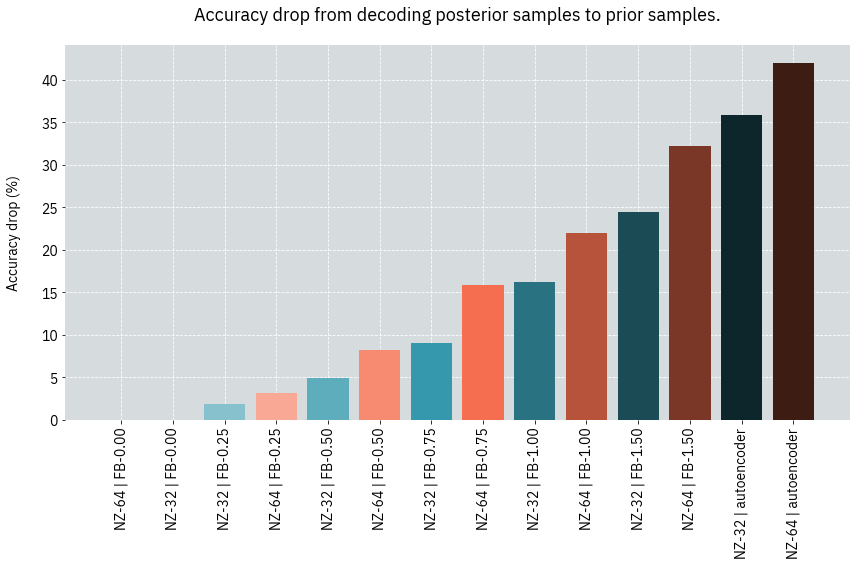

In [11]:
nz_32_c = {
    "autoencoder":"#0D262B", 
    "FB-0.00":"#AED6DE",
    "FB-0.25":"#86C1CD",
    "FB-0.50":"#5DADBD", 
    "FB-0.75":"#3598AC", 
    "FB-1.00":"#287281", 
    "FB-1.50":"#1B4C56"}

nz_64_c = {
    "autoencoder":"#3D1C14", 
    "FB-0.00":"#FBC5B9",
    "FB-0.25":"#F8A895",
    "FB-0.50":"#F68B72", 
    "FB-0.75":"#F46E4F", 
    "FB-1.00":"#B7533B", 
    "FB-1.50":"#7A3728"}

ax, fig = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))
names = list(df["clean_name"])
acc_drops = list(df["acc_drop"].values)

colors = []
for name in names:
    if "64" in name:
        colors.append(nz_64_c[name.split(" | ")[1]])
    else:
        colors.append(nz_32_c[name.split(" | ")[1]])
        

plt.bar(names, acc_drops, color=colors)
plt.title("Accuracy drop from decoding posterior samples to prior samples.", y=1.05, fontsize=18)
plt.ylabel("Accuracy drop (%)")
_ = plt.xticks(np.arange(len(names)), names, rotation='vertical')
plt.tight_layout()
plt.savefig(RESULT_DIR / f"bar_acc_drop_{MODE}.png", dpi=300, bbox="tight_inches")
plt.show()

# 2 Accuracy drop over sequence

In [12]:
AUTO_REGRESSIVE = False
MODE = 'TF' if AUTO_REGRESSIVE is False else 'AR'
RESULT_FILE = RESULT_DIR / f"result_acc_drop_over_sequence_{MODE}.pickle"

if os.path.exists(RESULT_FILE):
    print(f"Loading file {RESULT_FILE}, it existed.")
    results_acc_drop_over_seq = pickle.load( open( RESULT_FILE, "rb" ) )
else:
    results_acc_drop_over_seq = {}
    for r, p in PTB_run_name_paths.items():

        accs_prior_samples = []
        accs_posterior_samples = []
        label_masks = []

        latent_size = int(r.split("-")[4][-2:])
        
        vae_model = load_model_for_eval(p, device_name="cuda:0", 
                                        latent_size=latent_size, 
                                        add_latent_via_memory=True,
                                        add_latent_via_embeddings=False, 
                                        do_tie_weights=True, 
                                        do_tie_embedding_spaces=True,
                                        add_decoder_output_embedding_bias=False)


        N = len(validation_loader)
        with torch.no_grad():
            for batch_i, batch in enumerate(validation_loader):
                print(f"{batch_i:3d}/{N}", end="\r")

                batch = transfer_batch_to_device(batch, DEVICE)
                if batch["input_ids"].shape[0] != BATCH_SIZE:
                    continue

                for decode_sample_from_prior_mode in [False, True]:
                    vae_output = vae_model.forward(batch["input_ids"], 
                                                   1.0, 
                                                   batch["attention_mask"],
                                                   auto_regressive=AUTO_REGRESSIVE,
                                                    objective="beta-vae",
                                                    hinge_kl_loss_lambda=0.5,
                                                    return_latents=False,
                                                    return_log_q_z_x=False,
                                                    return_log_p_z=False,
                                                    return_mu_logvar=False,
                                                    return_exact_match=True,
                                                    return_cross_entropy=True,
                                                    return_embedding_distance=False,
                                                    reduce_seq_dim_embedding_loss="mean",
                                                    reduce_batch_dim_embedding_loss="mean",
                                                    return_predictions=True,
                                                    return_probabilities=False,
                                                    return_logits=False,
                                                    return_hidden_states=False,
                                                    return_last_hidden_state=False,
                                                    return_attention_to_latent=False,
                                                    return_attention_probs=False,
                                                    return_text_predictions=False,
                                                    tokenizer=None,
                                                    reduce_seq_dim_ce="none",
                                                    reduce_seq_dim_exact_match="none",
                                                    reduce_batch_dim_exact_match="none",
                                                    reduce_batch_dim_ce="none",
                                                    nucleus_sampling=False,
                                                    top_k=0,
                                                    top_p=0.9,
                                                    device_name="cuda:0",
                                                    decode_sample_from_prior=decode_sample_from_prior_mode)

                    labels = batch["input_ids"][:, 1:].contiguous()  # skip <s> token

                    # pad token is int 1
                    label_mask = (labels != 1).float()

                    masked_match = (vae_output["exact_match"] * label_mask)
    #                 masked_match_mean_over_seq = masked_match.sum(dim=0) / label_mask.sum(dim=0)

                    label_masks.append(label_mask)
                    if decode_sample_from_prior_mode is True:
                        accs_prior_samples.append(masked_match)
                    else:
                        accs_posterior_samples.append(masked_match)

                    if batch_i == 3:
                        break

        max_len = max([t.shape[1] for t in accs_prior_samples])
        print("max_len", max_len)

        accs_prior_samples = [torch.nn.functional.pad(a, (0, max_len - a.shape[1]), mode='constant', value=0) for a in accs_prior_samples]
        accs_posterior_samples = [torch.nn.functional.pad(a, (0, max_len - a.shape[1]), mode='constant', value=0) for a in accs_posterior_samples]
        label_masks = [torch.nn.functional.pad(a, (0, max_len - a.shape[1]), mode='constant', value=0) for a in label_masks]

        acc_prior_stack = torch.stack(accs_prior_samples, dim=0)
        acc_posterior_stack = torch.stack(accs_posterior_samples, dim=0)
        label_mask_stack = torch.stack(label_masks, dim=0)

        acc_prior_over_seq = (acc_prior_stack.sum(dim=0) / label_mask_stack.sum(dim=0)).mean(dim=0)
        acc_posterior_over_seq = (acc_posterior_stack.sum(dim=0) / label_mask_stack.sum(dim=0)).mean(dim=0)

        results_acc_drop_over_seq[r] ={
            "acc_prior": acc_prior_over_seq.unsqueeze(0).cpu().numpy(),
            "acc_posterior": acc_posterior_over_seq.unsqueeze(0).cpu().numpy(),
            "acc_drop": acc_posterior_over_seq.unsqueeze(0).cpu().numpy() - acc_prior_over_seq.unsqueeze(0).cpu().numpy()
        }

Loading file result-files/result_acc_drop_over_sequence_TF.pickle, it existed.


/home/cbarkhof/.conda/envs/thesisenv/lib/python3.6/site-packages/ipykernel_launcher.py:81: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


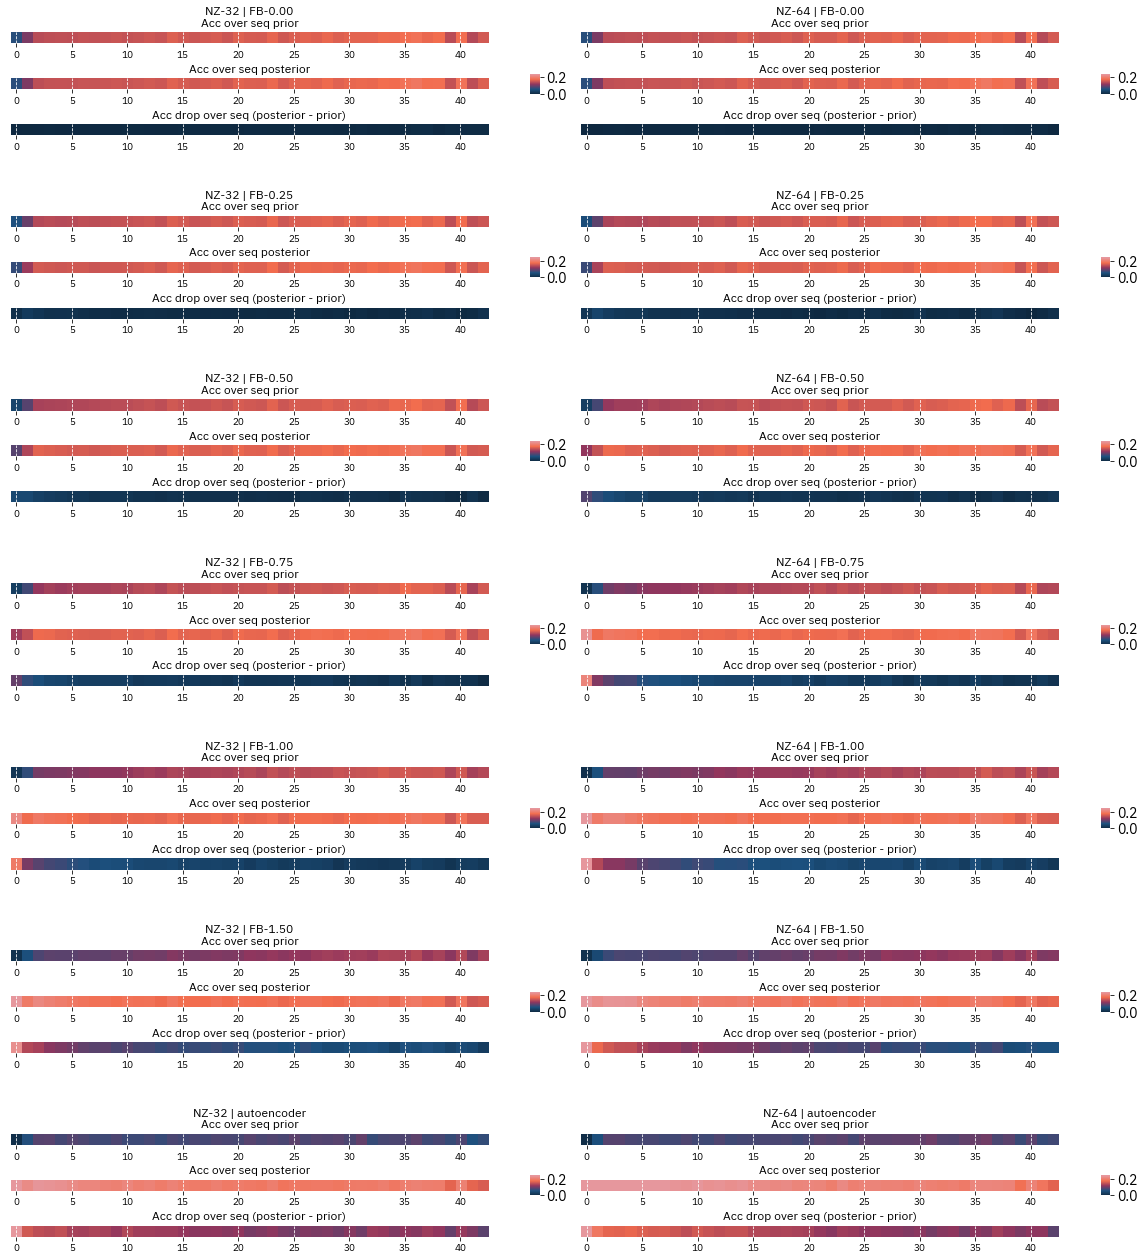

In [13]:
from matplotlib import gridspec
import matplotlib
import math

pickle.dump( results_acc_drop_over_seq, open( RESULT_FILE, "wb" ) )

order = [
    "2021-02-03-PTB-latent32-FB-0.00-run-14:32:09",
    "2021-02-02-PTB-latent32-FB-0.25-run-13:16:32",
    "2021-02-03-PTB-latent32-FB-0.5-run-09:31:02",
    "2021-02-02-PTB-latent32-FB-0.75-run-12:44:32",
    "2021-02-03-PTB-latent32-FB-1.0-run-11:43:17",
    "2021-02-03-PTB-latent32-FB-1.50-run-12:13:36",
    "2021-02-03-PTB-latent32-autoencoder-run-17:30:41",
    "2021-02-03-PTB-latent64-FB-0.00-run-17:14:10",
    "2021-02-02-PTB-latent64-FB-0.25-run-13:17:02",
    "2021-02-03-PTB-latent64-FB-0.50-run-12:29:58",
    "2021-02-02-PTB-latent64-FB-0.75-run-13:16:36",
    "2021-02-03-PTB-latent64-FB-1.0-run-13:06:00",
    "2021-02-03-PTB-latent64-FB-1.50-run-13:22:14",
    "2021-02-03-PTB-latent64-autoencoder-run-18:25:57"
]


fig, axs = plt.subplots(nrows=7*4, ncols=4, figsize=(16, 18), gridspec_kw={"width_ratios":[1, 0.02, 1, 0.02]})

for j in range(len(order)):
    i = j % 7
    start_row = i * 4
    
    run_name = order[j]
    r = results_acc_drop_over_seq[run_name]
    
    if "latent32" in run_name:
        col = 0
    else:
        col = 2
    
    axs[start_row, col].set_title(f"{get_clean_name(run_name)}\nAcc over seq prior", fontsize=12)
    im0 = axs[start_row, col].imshow(r['acc_prior'][:, :43], aspect=1.0, vmin=0.0, vmax=0.3, cmap=cmap) 
    axs[start_row, col].set_yticks([])
    axs[start_row, col].tick_params(labelsize=10) 
    
    axs[start_row+1, col].set_title("Acc over seq posterior", fontsize=12)
    im1 = axs[start_row+1, col].imshow(r['acc_posterior'][:, :43], aspect=1.0, vmin=0.0, vmax=0.3, cmap=cmap)
    axs[start_row+1, col].set_yticks([])
    axs[start_row+1, col].tick_params(labelsize=10) 
    
    axs[start_row+2, col].set_title("Acc drop over seq (posterior - prior)", fontsize=12)
    im2 = axs[start_row+2, col].imshow(r['acc_drop'][:, :43], aspect=1.0, vmin=0.0, vmax=0.3, cmap=cmap)
    axs[start_row+2, col].set_yticks([])
    axs[start_row+2, col].tick_params(labelsize=10) 
    
    cbar = plt.colorbar(im0, cax=axs[start_row+1, col+1], format=OOMFormatter(0, mathText=False))
    
for i in range(28):
    if i % 4 == 3:
        for col in [0, 2]:
            fig.delaxes(axs[i, col])

for i in range(28):
    if i % 4 != 1:
        for col in [1, 3]:
            fig.delaxes(axs[i, col])
        
plt.tight_layout()
plt.savefig(RESULT_DIR / "accuracy_drop_over_seq_big.png", dpi=300, bbox="tight_inches")
plt.show()

/home/cbarkhof/.conda/envs/thesisenv/lib/python3.6/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


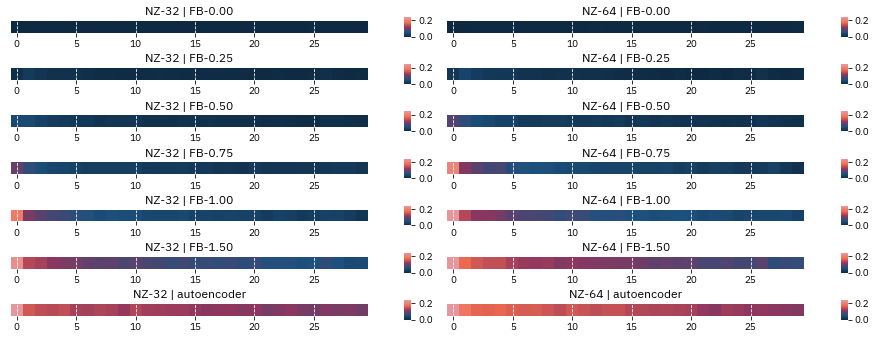

In [14]:
fig, axs = plt.subplots(nrows=7*2, ncols=4, figsize=(15, 6), gridspec_kw={"width_ratios":[1, 0.02, 1, 0.02]})

for j in range(len(order)):
    i = j % 7
    start_row = i * 2
    
    run_name = order[j]
    r = results_acc_drop_over_seq[run_name]
    
    if "latent32" in run_name:
        col = 0
    else:
        col = 2
        
    axs[start_row, col].set_title(f"{get_clean_name(run_name)}", fontsize=12)
    im0 = axs[start_row, col].imshow(r['acc_drop'][:, :30], aspect=1.0, vmin=0.0, vmax=0.3, cmap=cmap) 
    axs[start_row, col].set_yticks([])
    axs[start_row, col].tick_params(labelsize=10) 
    
    cbar = plt.colorbar(im0, cax=axs[start_row, col+1], format=OOMFormatter(0, mathText=False))
    axs[start_row, col+1].tick_params(labelsize=10) 
    
    fig.delaxes(axs[start_row+1, col+1])
    fig.delaxes(axs[start_row+1, col])

plt.savefig(RESULT_DIR / "accuracy_drop_over_seq_compact.png", dpi=300, bbox="tight_inches")

MODE = TF


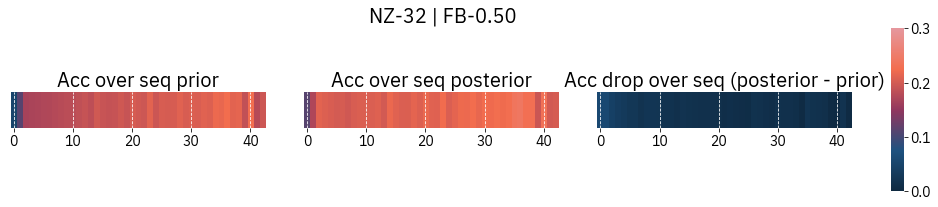

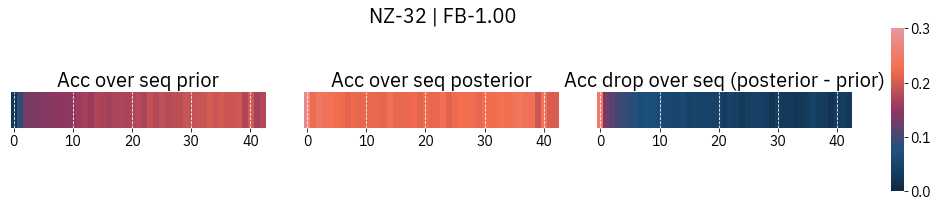

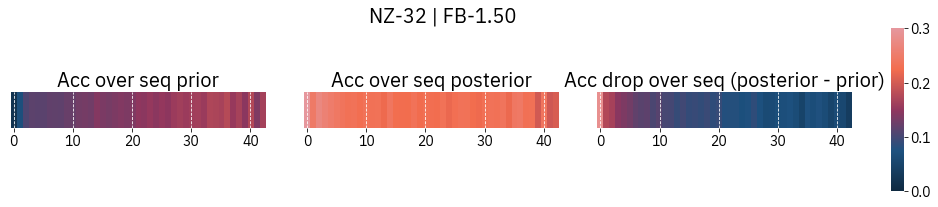

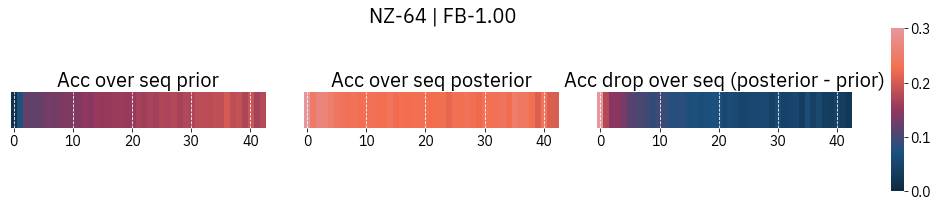

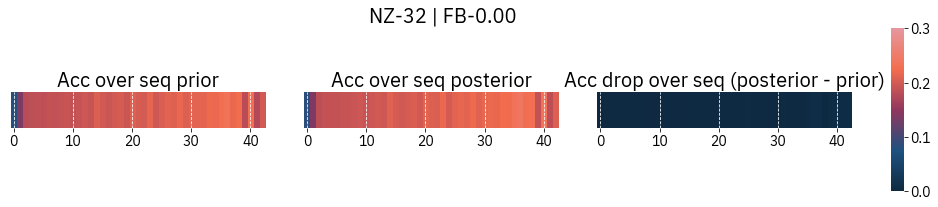

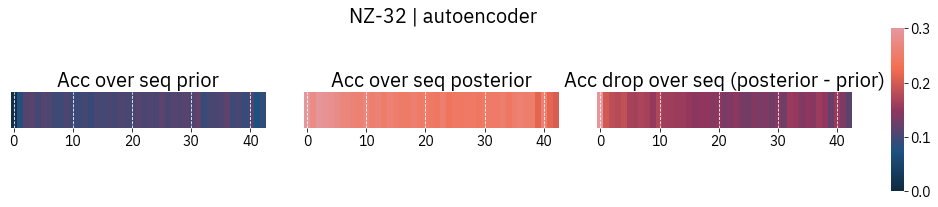

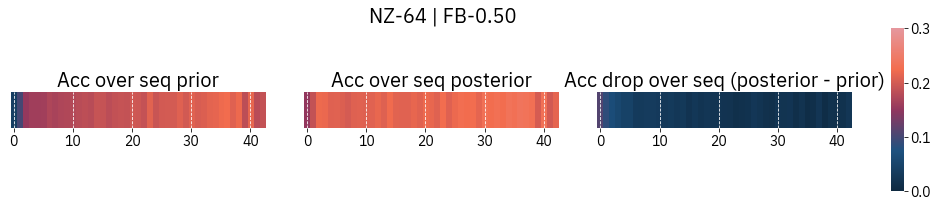

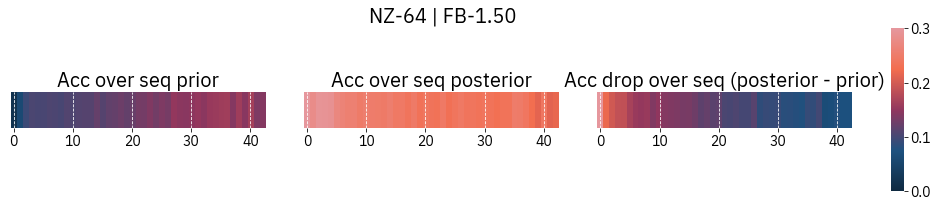

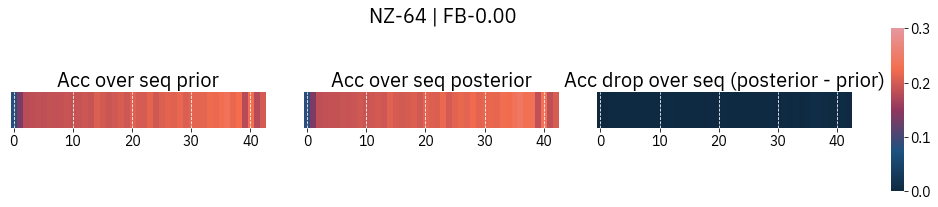

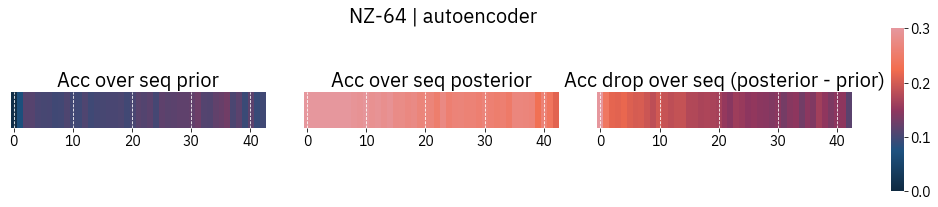

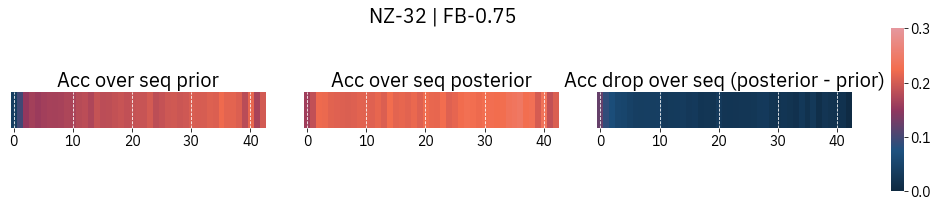

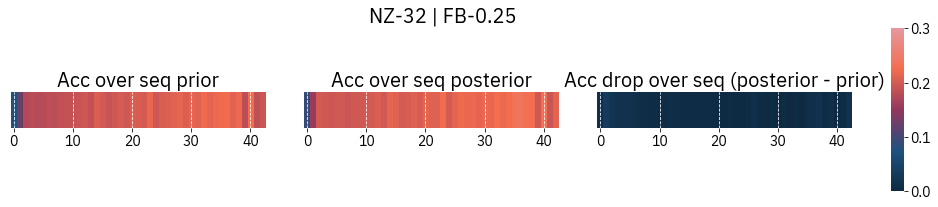

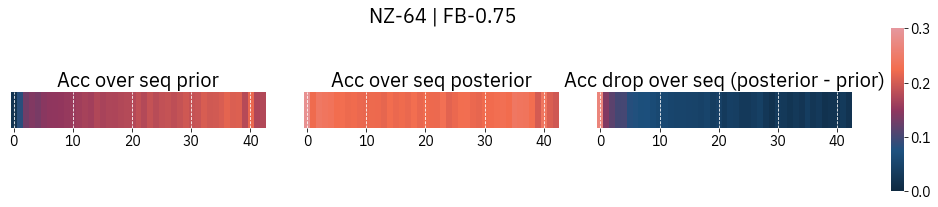

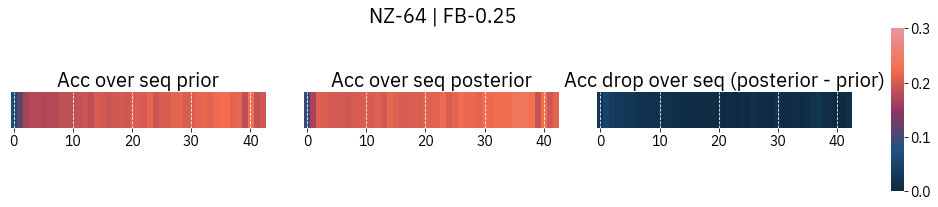

In [15]:

# print("MODE =", MODE)
# for name, r in results_acc_drop_over_seq.items():
    
#     fig, axs = plt.subplots(nrows=1, ncols=4, figsize=(16, 3), gridspec_kw={"width_ratios":[1, 1, 1, 0.05]})
    
#     plt.grid(b=None)
#     plt.suptitle(get_clean_name(name), size=20)

#     axs[0].set_title("Acc over seq prior")
#     im0 = axs[0].imshow(r['acc_prior'][:, :43], aspect=6.0, vmin=0.0, vmax=0.3, cmap=cmap) 
#     axs[0].set_yticks([])
    
#     axs[1].set_title("Acc over seq posterior")
#     im1 = axs[1].imshow(r['acc_posterior'][:, :43], aspect=6.0, vmin=0.0, vmax=0.3, cmap=cmap)
#     axs[1].set_yticks([])
    
#     axs[2].set_title("Acc drop over seq (posterior - prior)")
#     im2 = axs[2].imshow(r['acc_drop'][:, :43], aspect=6.0, vmin=0.0, vmax=0.3, cmap=cmap)
#     axs[2].set_yticks([])
    
#     plt.colorbar(im0, cax=axs[3])
#     plt.show()

In [34]:

# from matplotlib.gridspec import  GridSpec

# min_, max_ = 1000, -1000
# for n, r in results_jsd.items():
#     low, high = r["jsd_over_seq"].min(), r["jsd_over_seq"].max()
    
#     if low < min_:
#         min_ = low
    
#     if high > max_:
#         max_ = high

# # print("min val, max val", min_, max_)
# fig, ax = plt.subplots(nrows=14, ncols=4, figsize=(15, 15), gridspec_kw={"width_ratios":[1, 0.05, 1, 0.05]}) #, gridspec_kw={"width_ratios":[1, 1, 0.05]}

# # print("JSD(post||prior) - JSD(post||post_prime)")

# for i, (n, r) in enumerate(results_jsd.items()):
#     row = i % 7 
#     col = i // 7
    
#     row = row*2+1
    
#     if col == 1:
#         col = 2
        
# #     print(row, col)
    
#     im = ax[row, col].imshow(np.abs(r["jsd_over_seq_weighted_avg"][:30]).unsqueeze(0).numpy())  #, vmin=min_, vmax=max_ 

#     ax[row, col].set_axis_off()
    
#     ax[row, col].set_yticks([])
    
#     plt.colorbar(im, cax=ax[row, col+1])
    
#     counts = r["hist"].numpy()[:30].astype(float) / N_exp
#     bins = np.arange(30).astype(float)
    
# #     print(counts.shape, bins.shape)

#     # recover
#     # centroids = (bins[1:] + bins[:-1]) / 2 
#     counts_, bins_, _ = ax[row-1, col].hist(bins, bins=len(counts),
#                                             weights=counts, range=(min(bins), max(bins))) 
#     ax[row-1, col].set_title(get_clean_name(n), fontsize=12)
    
# for i in range(14): # change back to 6
#     if i % 2 == 0:
#         fig.delaxes(ax[i, 1])
#         fig.delaxes(ax[i, 3])
# # plt.colorbar(im0, cax=ax[-1, 2]) # uncomment for colorbar
# plt.tight_layout() 
# plt.suptitle("JSD(post||prior) - JSD(post||post')", size=20, y=1.03)
# plt.show()

# Run again 22 feb

In [8]:
# AUTO_REGRESSIVE = False
# MODE = 'TF' if AUTO_REGRESSIVE is False else 'AR'

all_acc_drop_results = {}

N_exp = 10
max_batches = -1

for MODE, AUTO_REGRESSIVE in zip(["TF", "AR"], [False, True]):
    RESULT_FILE = RESULT_DIR / f"result_acc_drop_{MODE}_22feb.pickle"
    
    # If already ran, do not run again
    if os.path.exists(RESULT_FILE):
        print(f"Loading file {RESULT_FILE}, it existed.")
        results_acc_drop = pickle.load( open( RESULT_FILE, "rb" ) )
    else:
        results_acc_drop = {}
    
    
    with torch.no_grad():
        for r, p in PTB_run_name_paths.items():
            print(r)

            if r in results_acc_drop:
                print("Did already do this. Skipping it.")
                continue

            all_label_masks = []
            all_accs_prior = []
            all_accs_post = []
            all_accs_post_2 = []

            latent_size = int(r.split("-")[4][-2:])

            vae_model = load_model_for_eval(p, device_name="cuda:0", 
                                            latent_size=latent_size, 
                                            add_latent_via_memory=True,
                                            add_latent_via_embeddings=False, 
                                            do_tie_weights=True, 
                                            do_tie_embedding_spaces=True,
                                            add_decoder_output_embedding_bias=False)


            N = len(validation_loader) if max_batches < 0 else max_batches

            for batch_i, batch in enumerate(validation_loader):
                print(f"{batch_i:3d}/{N}", end="\r")
                batch = transfer_batch_to_device(batch, DEVICE)

                accs_prior_batch, accs_post_batch, label_masks_batch = [], [], []

                for exp_i in range(N_exp):
                    
                    for decode_sample_from_prior_mode in [False, True]:
                        vae_output = vae_model.forward(batch["input_ids"], 
                                                       1.0, 
                                                       batch["attention_mask"],
                                                       auto_regressive=AUTO_REGRESSIVE,
                                                        objective="beta-vae",
                                                        hinge_kl_loss_lambda=0.5,
                                                        return_latents=False,
                                                        return_log_q_z_x=False,
                                                        return_log_p_z=False,
                                                        return_mu_logvar=False,
                                                        return_exact_match=True,
                                                        return_cross_entropy=True,
                                                        return_embedding_distance=False,
                                                        reduce_seq_dim_embedding_loss="mean",
                                                        reduce_batch_dim_embedding_loss="mean",
                                                        return_predictions=True,
                                                        return_probabilities=False,
                                                        return_logits=False,
                                                        return_hidden_states=False,
                                                        return_last_hidden_state=False,
                                                        return_attention_to_latent=False,
                                                        return_attention_probs=False,
                                                        return_text_predictions=False,
                                                        tokenizer=None,
                                                        reduce_seq_dim_ce="none",
                                                        reduce_seq_dim_exact_match="none",
                                                        reduce_batch_dim_exact_match="none",
                                                        reduce_batch_dim_ce="none",
                                                        nucleus_sampling=False,
                                                        top_k=0,
                                                        top_p=0.9,
                                                        device_name="cuda:0",
                                                        decode_sample_from_prior=decode_sample_from_prior_mode)


                        #masked_match = (vae_output["exact_match"] * label_mask)
                        #masked_acc = (masked_match.sum(dim=-1) / label_mask.sum(dim=-1)).mean().item()

                        if decode_sample_from_prior_mode is True:

                            labels = batch["input_ids"][:, 1:].contiguous()  # skip <s> token
                            label_mask = (labels != 1).float()  # pad token is int 1
                            label_masks_batch.append(label_mask.cpu())

                            accs_prior_batch.append(vae_output["exact_match"].cpu())

                        else:
                            accs_post_batch.append(vae_output["exact_match"].cpu())

                ### END EXPERIMENTS

                # make a reordered posterior list, to compare posterior 
                # to posterior (and account for internal variability)
                re_order = list(np.arange(1, N_exp)) + [0]          
                accs_poster_reorder = [accs_post_batch[i] for i in re_order]  

                # Cat all experiments of this batch
#                 accs_post_batch = torch.cat(accs_post_batch, dim=0)
#                 accs_prior_batch = torch.cat(accs_prior_batch, dim=0)
#                 label_masks_batch = torch.cat(label_masks_batch, dim=0)
#                 accs_poster_reorder = torch.cat(accs_poster_reorder, dim=0)

                all_label_masks.append(label_masks_batch)
                all_accs_prior.append(accs_prior_batch)
                all_accs_post.append(label_masks_batch)
                all_accs_post_2.append(accs_poster_reorder)

                if batch_i == max_batches - 1:
                    break

            ### END BATCHES 

            results_acc_drop[r] ={
                "acc_prior": all_accs_prior,
                "acc_post_2": all_accs_post_2,
                "acc_post": all_accs_post,
                "label_masks": all_label_masks
            }
            
            print("*"*40)
            print("Dumping results of this model!")
            print("*"*40)

            pickle.dump( results_acc_drop, open( RESULT_FILE, "wb" ))

        ### END MODE 
        all_acc_drop_results[MODE] = results_acc_drop
        break # <- skip AR for now

Loading file result-files/result_acc_drop_TF_22feb.pickle, it existed.
2021-02-03-PTB-latent32-FB-0.5-run-09:31:02
Did already do this. Skipping it.
2021-02-03-PTB-latent32-FB-1.0-run-11:43:17
Did already do this. Skipping it.
2021-02-03-PTB-latent32-FB-1.50-run-12:13:36
Did already do this. Skipping it.
2021-02-03-PTB-latent64-FB-1.0-run-13:06:00
Did already do this. Skipping it.
2021-02-03-PTB-latent32-FB-0.00-run-14:32:09
Did already do this. Skipping it.
2021-02-03-PTB-latent32-autoencoder-run-17:30:41
Did already do this. Skipping it.
2021-02-03-PTB-latent64-FB-0.50-run-12:29:58
Did already do this. Skipping it.
2021-02-03-PTB-latent64-FB-1.50-run-13:22:14
Did already do this. Skipping it.
2021-02-03-PTB-latent64-FB-0.00-run-17:14:10
Did already do this. Skipping it.
2021-02-03-PTB-latent64-autoencoder-run-18:25:57
Did already do this. Skipping it.
2021-02-02-PTB-latent32-FB-0.75-run-12:44:32
Did already do this. Skipping it.
2021-02-02-PTB-latent32-FB-0.25-run-13:16:32
Did alread

In [9]:
plot_results = {}

for run_name, results in results_acc_drop.items():
    
    masks = results["label_masks"]

    relative_positions = []
    absolute_positions = []
    avg_acc_drop = []

    # Loop over batches
    for i in range(len(results["acc_post"])):

        # Average over experiments
        acc_prior_avg = torch.stack(results["acc_prior"][i], dim=0).mean(dim=0)
        acc_post_avg = torch.stack(results["acc_post"][i], dim=0).mean(dim=0)
        acc_post_2_avg = torch.stack(results["acc_post_2"][i], dim=0).mean(dim=0)
        
        #print(acc_post_2_avg.shape)
        
        acc_drop = (acc_post_avg - acc_prior_avg) - (acc_post_avg - acc_post_2_avg)

        # Move all sequences to the 0, 1-range
        for seq_i in range(len(acc_prior_avg)):

            seq_mask = masks[i][0][seq_i, :]
            
            acc_drop_seq = acc_drop[seq_i, :]

            x = (seq_mask == 0).nonzero(as_tuple=True)[0]

            if len(x) != 0:
                N_elem = x[0].item()
            else:
                N_elem = len(seq_mask)

            pos = torch.arange(1, N_elem+1) 
            rel_pos = pos / N_elem
            acc_drop_seq = acc_drop_seq[:N_elem]

            absolute_positions.extend(pos.tolist())
            relative_positions.extend(rel_pos.tolist())
            avg_acc_drop.extend(acc_drop_seq.tolist())
    
    plot_results[run_name] = {
        "absolute_positions": absolute_positions,
        "relative_positions": relative_positions,
        "avg_acc_drop": avg_acc_drop
    }

RELATIVE_POSITIONS


/home/cbarkhof/.conda/envs/thesisenv/lib/python3.6/site-packages/ipykernel_launcher.py:78: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "bbox" which is no longer supported as of 3.3 and will become an error two minor releases later


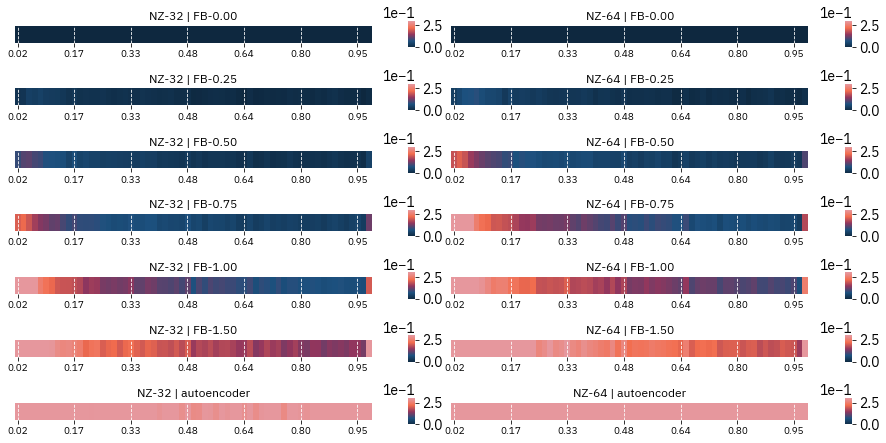

ABSOLUTE_POSITIONS


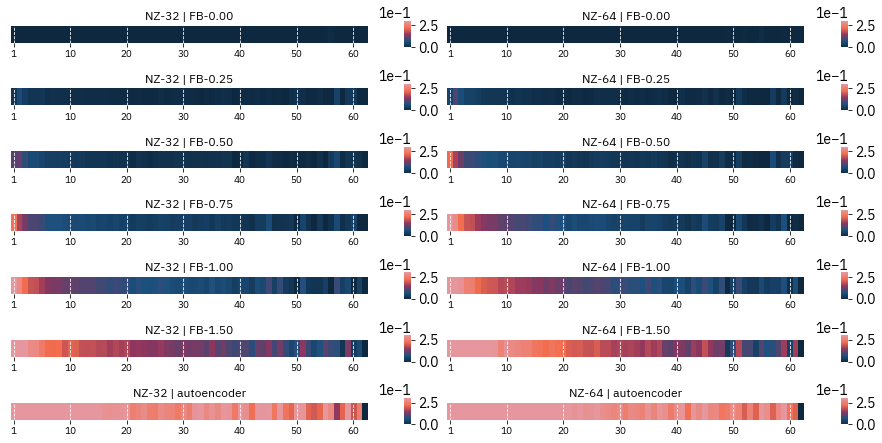

In [21]:
from scipy import stats 


order = [
    "2021-02-03-PTB-latent32-FB-0.00-run-14:32:09",
    "2021-02-02-PTB-latent32-FB-0.25-run-13:16:32",
    "2021-02-03-PTB-latent32-FB-0.5-run-09:31:02",
    "2021-02-02-PTB-latent32-FB-0.75-run-12:44:32",
    "2021-02-03-PTB-latent32-FB-1.0-run-11:43:17",
    "2021-02-03-PTB-latent32-FB-1.50-run-12:13:36",
    "2021-02-03-PTB-latent32-autoencoder-run-17:30:41",
    "2021-02-03-PTB-latent64-FB-0.00-run-17:14:10",
    "2021-02-02-PTB-latent64-FB-0.25-run-13:17:02",
    "2021-02-03-PTB-latent64-FB-0.50-run-12:29:58",
    "2021-02-02-PTB-latent64-FB-0.75-run-13:16:36",
    "2021-02-03-PTB-latent64-FB-1.0-run-13:06:00",
    "2021-02-03-PTB-latent64-FB-1.50-run-13:22:14",
    "2021-02-03-PTB-latent64-autoencoder-run-18:25:57"
]


plt.rcParams["figure.figsize"] = (10, 6)

N_bins = 63

for mode in ["relative_positions", "absolute_positions"]:
    print(mode.upper())
    
    fig, axs = plt.subplots(nrows=7*2, ncols=4, figsize=(15, 8), gridspec_kw={"width_ratios":[1, 0.02, 1, 0.02]})
    
    for j in range(len(order)):
        i = j % 7
        start_row = i * 2
        
        # Get results
        run_name = order[j]
        results = plot_results[run_name]
        
        # Calculate binned stats
        x = results[mode]
        y = results["avg_acc_drop"]
        bin_means, bin_edges, bin_ids = stats.binned_statistic(x, y, statistic ='mean', bins = N_bins)

        # Which column
        if "latent32" in run_name:
            col = 0
        else:
            col = 2
    
        # Plot
        axs[start_row, col].set_title(f"{get_clean_name(run_name)}", fontsize=12)
        im0 = axs[start_row, col].imshow(bin_means[None, :], aspect=3.0, cmap=cmap, vmin=0, vmax=0.3)
        
        # Y-TICKS
        axs[start_row, col].set_yticks([])
        
        # X-TICKS
        locs, labels = np.arange(N_bins)[::10], bin_edges[:-1][::10]
        
        if mode == "relative_positions":
            labels = [f"{l:.2f}" for l in labels]
        else:
            labels = [f"{int(l)}" for l in labels]

        axs[start_row, col].set_xticks(locs) 
        axs[start_row, col].set_xticklabels(labels, fontsize=10)
    
        #axs[start_row+1, col].hist(bin_ids, bins=N_bins)
        
        # Color bar
        cbar = plt.colorbar(im0, cax=axs[start_row, col+1], format=OOMFormatter(-1, mathText=False)) #

        fig.delaxes(axs[start_row+1, col+1])
#         fig.delaxes(axs[start_row+2, col+1])
        fig.delaxes(axs[start_row+1, col])
        
    #fig.suptitle(mode)
    plt.savefig(RESULT_DIR / f"NEW_accuracy_drop_over_seq_{mode}.png", dpi=300, bbox="tight_inches")
    plt.show()